# Importação dos dados
A tabela de interesse vem do db bigquery; o foco é nos dados do Ministério da Saúde sobre a Cobertura da Saúde Básica de 07/2007 a 12/2020.

In [2]:
import seaborn as sns
import pandas as pd
import sqlalchemy as sa
import basedosdados as bd
import re

In [7]:
# Dados de Cobertura da Atenção Básica - Já baixados e passados para o MySQL
df = bd.read_table(dataset_id='br_ms_atencao_basica',
table_id='municipio',
billing_project_id="utility-zenith-381413")

Downloading: 100%|█████████████████████████████████████████████████████████| 901944/901944 [02:15<00:00, 6665.80rows/s]


In [8]:
# Dados com nomes de municípios - Já baixado, falta passar para o MySQL
municipios = bd.read_table(dataset_id='br_bd_diretorios_brasil',
table_id='municipio',
billing_project_id="utility-zenith-381413")

Downloading: 100%|█████████████████████████████████████████████████████████████| 5570/5570 [00:01<00:00, 3066.38rows/s]


In [9]:
# Dados do IBGE de 2010 por setor censitário - Já baixado, falta tratar, passando para granularidade de município, renomear nomes de colunas
# e passar para o MySQL
ibge = bd.read_table(dataset_id='br_ibge_censo_demografico',
table_id='setor_censitario_basico_2010',
billing_project_id="utility-zenith-381413")

Downloading: 100%|█████████████████████████████████████████████████████████| 310120/310120 [01:34<00:00, 3282.61rows/s]


# Tratamento de dados da tabela IBGE

In [10]:
ibge

,id_setor_censitario,sigla_uf,v001,v002,v003,v004,v005,v006,v007,v008,v009,v010,v011,v012
0,130002905000001,AM,146.0,796.0,5.45,7.04,563.03,2037839.17,1110.84,3430898.17,240.11,654545.56,932.21,1904167.36
1,130002905000002,AM,196.0,1090.0,5.56,8.00,558.40,853145.39,710.69,978401.81,243.57,321167.01,591.07,574797.84
2,130002905000003,AM,146.0,806.0,5.52,9.77,655.95,330577.16,825.59,275540.61,285.81,234929.56,798.75,246895.13
3,130002905000004,AM,23.0,118.0,5.13,9.66,460.61,81966.70,588.56,26341.08,147.79,68960.77,564.27,26355.92
4,130002905000006,AM,103.0,564.0,5.48,7.60,538.83,146533.92,637.93,109844.51,208.37,113619.16,576.35,102096.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310115,355620605000113,SP2,299.0,1083.0,3.62,3.45,1030.88,712873.14,1104.77,682224.77,629.68,479486.54,917.18,434649.62
310116,355640405000064,SP2,45.0,163.0,3.62,2.60,914.44,885220.71,1055.13,872646.69,534.83,729176.21,1005.79,900145.35
310117,355640405000070,SP2,224.0,811.0,3.62,3.07,779.52,288458.65,914.20,214786.02,438.55,233681.81,757.80,161687.76
310118,355645305000027,SP2,244.0,883.0,3.62,2.79,669.79,326942.03,873.95,247750.06,420.79,249017.81,787.54,177026.47


## Tratar nome das colunas

In [11]:
ibge.columns

Index(['id_setor_censitario', 'sigla_uf', 'v001', 'v002', 'v003', 'v004',
       'v005', 'v006', 'v007', 'v008', 'v009', 'v010', 'v011', 'v012'],
      dtype='object')

In [13]:
cols_renomeadas = ['id_setor_censitario', 'sigla_uf',
                  'domicilios_particulares',
                  'moradores_domicilios_partic',
                  'media_moradores_dom_partic',
                  'variancia_moradores_dom_partic',
                  'rendimento_nominal_medio_com_sem_rendimento',
                  'variancia_rendimento_com_sem_rendimento',
                  'rendimento_nominal_medio_com_rendimento',
                  'variancia_rendimento_medio_com_rendimento',
                  'valor_rendimento_10anos_com_sem_rendimento',
                  'variancia_valor_rendimento_10anos_com_sem_rendimento',
                  'valor_rendimento_10anos_com_rendimento',
                  'variancia_valor_rendimento_10anos_com_rendimento',
                  ]
ibge.columns = cols_renomeadas

## Pegar nome dos municípios para cada setor censitário

In [14]:
ibge[ibge['id_setor_censitario'].str.startswith('1200013')]

,id_setor_censitario,sigla_uf,domicilios_particulares,moradores_domicilios_partic,media_moradores_dom_partic,variancia_moradores_dom_partic,rendimento_nominal_medio_com_sem_rendimento,variancia_rendimento_com_sem_rendimento,rendimento_nominal_medio_com_rendimento,variancia_rendimento_medio_com_rendimento,valor_rendimento_10anos_com_sem_rendimento,variancia_valor_rendimento_10anos_com_sem_rendimento,valor_rendimento_10anos_com_rendimento,variancia_valor_rendimento_10anos_com_rendimento
6925,120001305000006,AC,129.0,483.0,3.74,3.21,1761.27,1.733162e+08,1877.72,1.846502e+08,709.22,60287872.14,1277.96,1.081390e+08
6926,120001305000010,AC,229.0,855.0,3.73,3.18,415.72,3.055207e+05,528.88,3.289682e+05,204.70,160503.54,498.99,2.447109e+05
6927,120001305000014,AC,210.0,829.0,3.95,4.64,820.13,1.016400e+06,897.02,1.042855e+06,372.54,530600.16,728.19,7.789214e+05
6928,120001305000015,AC,146.0,596.0,4.08,4.03,442.62,2.695755e+05,659.41,2.585456e+05,212.92,141948.39,505.28,1.893740e+05
6929,120001305000016,AC,219.0,812.0,3.71,4.87,404.03,1.731169e+05,429.52,1.730901e+05,182.62,106242.49,387.92,1.461728e+05
140023,120001305000001,AC,282.0,957.0,3.39,2.60,1368.91,3.707462e+07,1601.80,4.303361e+07,758.58,13786625.70,1249.62,2.211442e+07
150095,120001305000002,AC,342.0,1203.0,3.52,2.63,737.47,8.205046e+05,805.80,8.415344e+05,407.43,510601.28,716.42,6.767703e+05
150096,120001305000007,AC,104.0,366.0,3.52,2.97,851.87,7.416341e+05,868.57,7.416684e+05,413.81,479566.65,766.61,6.188618e+05
159862,120001305000008,AC,218.0,796.0,3.65,3.80,430.39,3.870401e+05,625.50,4.408154e+05,206.53,191364.01,548.22,3.211726e+05
166982,120001305000003,AC,482.0,1700.0,3.53,2.88,606.40,1.108707e+06,767.15,1.279744e+06,411.93,757913.63,689.39,1.077560e+06


In [15]:
ibge[ibge['sigla_uf'] == 'SP1']

,id_setor_censitario,sigla_uf,domicilios_particulares,moradores_domicilios_partic,media_moradores_dom_partic,variancia_moradores_dom_partic,rendimento_nominal_medio_com_sem_rendimento,variancia_rendimento_com_sem_rendimento,rendimento_nominal_medio_com_rendimento,variancia_rendimento_medio_com_rendimento,valor_rendimento_10anos_com_sem_rendimento,variancia_valor_rendimento_10anos_com_sem_rendimento,valor_rendimento_10anos_com_rendimento,variancia_valor_rendimento_10anos_com_rendimento
80193,355030801000007,SP1,249.0,690.0,2.77,2.47,901.47,1568830.60,1394.19,1740438.09,717.13,1180429.97,1308.44,1380654.87
80194,355030801000009,SP1,245.0,693.0,2.83,2.19,1487.51,3089961.53,1584.52,3137972.62,1006.66,2001789.21,1393.67,2232522.23
80195,355030801000011,SP1,267.0,722.0,2.70,1.71,2166.10,3905966.72,2259.17,3863363.52,1508.51,2861443.03,1924.03,2850134.57
80196,355030801000013,SP1,218.0,615.0,2.82,1.54,3266.75,10691976.73,3327.81,10688612.72,1945.66,6910640.74,2618.23,7540105.21
80197,355030801000028,SP1,157.0,436.0,2.78,1.75,1695.44,3647932.44,1901.31,3699833.70,1156.15,2589581.77,1674.14,2883660.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309707,355030894000257,SP1,120.0,434.0,3.62,2.09,492.24,231563.70,777.22,142966.36,518.75,282093.62,810.55,203903.27
309708,355030895000047,SP1,104.0,376.0,3.62,3.09,495.17,248502.77,804.66,153301.91,456.33,210374.65,749.03,125644.32
309709,355030896000083,SP1,272.0,984.0,3.62,3.27,618.71,326933.76,809.09,273242.16,339.26,224222.24,730.18,197072.86
309710,355030896000109,SP1,222.0,803.0,3.62,3.02,612.20,809072.25,808.98,910546.49,451.76,407349.07,747.82,453012.38


In [16]:
ibge.id_setor_censitario.str[:2].value_counts()

35    66096
31    32564
33    27769
29    23782
43    22332
41    17465
23    13276
26    12379
42    11882
52     9434
21     8802
15     8769
32     6380
51     5929
13     5641
25     5548
22     5251
53     4349
24     4289
50     4207
27     3724
28     3297
11     2346
17     2101
12      874
14      824
16      810
Name: id_setor_censitario, dtype: int64

In [17]:
ibge[ibge['id_setor_censitario'].str.startswith('12')].count()

id_setor_censitario                                     874
sigla_uf                                                874
domicilios_particulares                                 874
moradores_domicilios_partic                             874
media_moradores_dom_partic                              874
variancia_moradores_dom_partic                          874
rendimento_nominal_medio_com_sem_rendimento             874
variancia_rendimento_com_sem_rendimento                 874
rendimento_nominal_medio_com_rendimento                 871
variancia_rendimento_medio_com_rendimento               871
valor_rendimento_10anos_com_sem_rendimento              874
variancia_valor_rendimento_10anos_com_sem_rendimento    874
valor_rendimento_10anos_com_rendimento                  873
variancia_valor_rendimento_10anos_com_rendimento        873
dtype: int64

In [18]:
path_setores_censitarios = 'data/setor_censitario'

In [19]:
siglas_estados = ['ac', 'am', 'ap', 'rr', 'ro', 'pa', 'to', 'ma', 'ce', 'pi', 'rn', 'pb', 'pe',
                  'al', 'se', 'ba', 'ms', 'go', 'df', 'mt', 'mg', 'es', 'rj', 'sp1', 'sp2', 'pr', 'sc', 'rs']

In [20]:
# O Cidades Sustentáveis tem tabelas Excel com informações de todos os municípios; achei o link pelo Google, então foi mais fácil automatizar assim
# https://www.cidadessustentaveis.org.br/pagina/dados-censo-2010
for sigla in siglas_estados:
    print(f'https://www.cidadessustentaveis.org.br/arquivos/SIG/Senso2010_Dados/{sigla.upper()}/Base_informa%C3%A7%C3%B5es_setores2010_sinopse_{sigla.upper()}.xls')
# Excessão: SP tá dividida em duas áreas, nos seguintes links:
print('https://www.cidadessustentaveis.org.br/arquivos/SIG/Senso2010_Dados/SP_RMSP-RMSANTOS/Base_informa%C3%A7%C3%B5es_setores2010_sinopse_SP_RM_S%C3%A3o_Paulo_Santos.xls')
print('https://www.cidadessustentaveis.org.br/arquivos/SIG/Senso2010_Dados/SP_SEM-RMSP-RMSANTOS/Base_informa%C3%A7%C3%B5ese_setores2010_sinopse_SP_Exclusive_RM.xls')

https://www.cidadessustentaveis.org.br/arquivos/SIG/Senso2010_Dados/AC/Base_informa%C3%A7%C3%B5es_setores2010_sinopse_AC.xls
https://www.cidadessustentaveis.org.br/arquivos/SIG/Senso2010_Dados/AM/Base_informa%C3%A7%C3%B5es_setores2010_sinopse_AM.xls
https://www.cidadessustentaveis.org.br/arquivos/SIG/Senso2010_Dados/AP/Base_informa%C3%A7%C3%B5es_setores2010_sinopse_AP.xls
https://www.cidadessustentaveis.org.br/arquivos/SIG/Senso2010_Dados/RR/Base_informa%C3%A7%C3%B5es_setores2010_sinopse_RR.xls
https://www.cidadessustentaveis.org.br/arquivos/SIG/Senso2010_Dados/RO/Base_informa%C3%A7%C3%B5es_setores2010_sinopse_RO.xls
https://www.cidadessustentaveis.org.br/arquivos/SIG/Senso2010_Dados/PA/Base_informa%C3%A7%C3%B5es_setores2010_sinopse_PA.xls
https://www.cidadessustentaveis.org.br/arquivos/SIG/Senso2010_Dados/TO/Base_informa%C3%A7%C3%B5es_setores2010_sinopse_TO.xls
https://www.cidadessustentaveis.org.br/arquivos/SIG/Senso2010_Dados/MA/Base_informa%C3%A7%C3%B5es_setores2010_sinopse_MA.xls


In [21]:
# Aqui estou gerando uma lista de dataframes com os dados de todas as planilhas extraídas, a fim de ter os dados do nome do município
# de cada setor censitário
df_setores_censitarios = [pd.read_excel(f'{path_setores_censitarios}/{estado}.xls') for estado in siglas_estados]

In [22]:
df_setores_censitarios = [df[df.columns[:20]] for df in df_setores_censitarios]

In [23]:
df_setores_censitarios[10].head()

,Cod_setor,Cod_Grandes Regiões,Nome_Grande_Regiao,Cod_UF,Nome_da_UF,Cod_meso,Nome_da_meso,Cod_micro,Nome_da_micro,Cod_RM,Nome_da_RM,Cod_municipio,Nome_do_municipio,Cod_distrito,Nome_do_distrito,Cod_subdistrito,Nome_do_subdistrito,Cod_bairro,Nome_do_bairro,Situacao_setor
0,240010905000001,2,Região Nordeste,24,Rio Grande do Norte,2402,Central Potiguar,24012,Seridó Oriental,0,Municípios não pertencentes a estrutura de RM,2400109,ACARI,240010905,ACARI,24001090500,ACARI,2400109005,Petrópolis,1
1,240010905000002,2,Região Nordeste,24,Rio Grande do Norte,2402,Central Potiguar,24012,Seridó Oriental,0,Municípios não pertencentes a estrutura de RM,2400109,ACARI,240010905,ACARI,24001090500,ACARI,2400109006,Senador Dinarte de Medeiros Mariz,2
2,240010905000003,2,Região Nordeste,24,Rio Grande do Norte,2402,Central Potiguar,24012,Seridó Oriental,0,Municípios não pertencentes a estrutura de RM,2400109,ACARI,240010905,ACARI,24001090500,ACARI,2400109002,Luiz Gonzaga Bezerra,1
3,240010905000004,2,Região Nordeste,24,Rio Grande do Norte,2402,Central Potiguar,24012,Seridó Oriental,0,Municípios não pertencentes a estrutura de RM,2400109,ACARI,240010905,ACARI,24001090500,ACARI,2400109007,Padre José Dantas Cortez,1
4,240010905000005,2,Região Nordeste,24,Rio Grande do Norte,2402,Central Potiguar,24012,Seridó Oriental,0,Municípios não pertencentes a estrutura de RM,2400109,ACARI,240010905,ACARI,24001090500,ACARI,2400109003,Major Ari de Pinho,1


In [24]:
ibge.dtypes

id_setor_censitario                                      object
sigla_uf                                                 object
domicilios_particulares                                 float64
moradores_domicilios_partic                             float64
media_moradores_dom_partic                              float64
variancia_moradores_dom_partic                          float64
rendimento_nominal_medio_com_sem_rendimento             float64
variancia_rendimento_com_sem_rendimento                 float64
rendimento_nominal_medio_com_rendimento                 float64
variancia_rendimento_medio_com_rendimento               float64
valor_rendimento_10anos_com_sem_rendimento              float64
variancia_valor_rendimento_10anos_com_sem_rendimento    float64
valor_rendimento_10anos_com_rendimento                  float64
variancia_valor_rendimento_10anos_com_rendimento        float64
dtype: object

In [25]:
# Convertendo no mesmo tipo de dados para poder fazer o Merge
ibge['id_setor_censitario'] = ibge['id_setor_censitario'].astype('int64')

In [131]:
# O código a seguir estava exigindo muito tempo, por este motivo optei por enviar os dados dos setores censitários diretamente para o SQL,
# visto que o SQL é mais rápido para realizar os Joins do que o Python.

# Mesclando todos os dados do df IBGE com os dados de municípios coletados na lista de dfs de setor censitário
#for df in df_setores_censitarios:
# print('Começando a mesclar:', df['Nome_da_UF '][0])
# ibge = ibge.merge(df, left_on='id_setor_censitario', right_on='Cod_setor', how='left')
# print('Finalizada mesclagem')
# print('-' * 50)

Começando a mesclar: Acre
Finalizada mesclagem
--------------------------------------------------
Começando a mesclar: Amazonas
Finalizada mesclagem
--------------------------------------------------
Começando a mesclar: Amapá
Finalizada mesclagem
--------------------------------------------------
Começando a mesclar: Roraima
Finalizada mesclagem
--------------------------------------------------
Começando a mesclar: Rondônia
Finalizada mesclagem
--------------------------------------------------
Começando a mesclar: Pará
Finalizada mesclagem
--------------------------------------------------
Começando a mesclar: Tocantins
Finalizada mesclagem
--------------------------------------------------
Começando a mesclar: Maranhão
Finalizada mesclagem
--------------------------------------------------
Começando a mesclar: Ceará
Finalizada mesclagem
--------------------------------------------------
Começando a mesclar: Piauí
Finalizada mesclagem
------------------------------------------------

KeyboardInterrupt: 

In [167]:
ibge.sample(5)

,id_setor_censitario,sigla_uf,v001,v002,v003,v004,v005,v006,v007,v008,...,Nome_da_RM_y,Cod_municipio_y,Nome_do_municipio_y,Cod_distrito_y,Nome_do_distrito_y,Cod_subdistrito_y,Nome_do_subdistrito_y,Cod_bairro_y,Nome_do_bairro_y,Situacao_setor_y
59619,420140610000001,SC,73.0,195.0,2.67,2.06,639.82,336023.37,805.29,288860.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214885,270770105000083,AL,95.0,338.0,3.56,2.08,685.79,256265.42,775.60,219736.20,...,RM Maceió,2707701.0,RIO LARGO,270770105.0,RIO LARGO,2.707701e+10,RIO LARGO,2.707701e+09,RIO LARGO (todos os setores),3.0
198506,431490205000929,RS,250.0,826.0,3.30,3.14,873.32,649136.88,961.81,629716.36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
284055,210910605000039,MA,110.0,383.0,3.48,2.64,498.90,206228.44,512.89,204823.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226753,330455705230604,RJ,230.0,706.0,3.07,1.55,1381.83,1221613.20,1550.35,1108780.35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# Concatenando os dados de todos os dataframes de setores censitários para facilitar a exportação para SQL
df_setores_censitarios = pd.concat(df_setores_censitarios)

In [27]:
df_setores_censitarios.columns

Index(['Cod_setor', 'Cod_Grandes Regiões', 'Nome_Grande_Regiao', 'Cod_UF',
       'Nome_da_UF ', 'Cod_meso', 'Nome_da_meso', 'Cod_micro', 'Nome_da_micro',
       'Cod_RM', 'Nome_da_RM', 'Cod_municipio', 'Nome_do_municipio',
       'Cod_distrito', 'Nome_do_distrito', 'Cod_subdistrito',
       'Nome_do_subdistrito', 'Cod_bairro', 'Nome_do_bairro',
       'Situacao_setor'],
      dtype='object')

In [28]:
# Ajeitando o nome das colunas 
df_setores_censitarios.columns = [re.sub(' ', '_', col.lower().strip()) for col in df_setores_censitarios.columns]

## Agregar dados para diminuir granularidade de setor censitário para município

In [40]:
ibge['cod_municipio'] = ibge['id_setor_censitario'].astype(str).str[0:7]

In [41]:
ibge.head()

,id_setor_censitario,sigla_uf,domicilios_particulares,moradores_domicilios_partic,media_moradores_dom_partic,variancia_moradores_dom_partic,rendimento_nominal_medio_com_sem_rendimento,variancia_rendimento_com_sem_rendimento,rendimento_nominal_medio_com_rendimento,variancia_rendimento_medio_com_rendimento,valor_rendimento_10anos_com_sem_rendimento,variancia_valor_rendimento_10anos_com_sem_rendimento,valor_rendimento_10anos_com_rendimento,variancia_valor_rendimento_10anos_com_rendimento,cod_municipio
0,130002905000001,AM,146.0,796.0,5.45,7.04,563.03,2037839.17,1110.84,3430898.17,240.11,654545.56,932.21,1904167.36,1300029
1,130002905000002,AM,196.0,1090.0,5.56,8.00,558.40,853145.39,710.69,978401.81,243.57,321167.01,591.07,574797.84,1300029
2,130002905000003,AM,146.0,806.0,5.52,9.77,655.95,330577.16,825.59,275540.61,285.81,234929.56,798.75,246895.13,1300029
3,130002905000004,AM,23.0,118.0,5.13,9.66,460.61,81966.70,588.56,26341.08,147.79,68960.77,564.27,26355.92,1300029
4,130002905000006,AM,103.0,564.0,5.48,7.60,538.83,146533.92,637.93,109844.51,208.37,113619.16,576.35,102096.93,1300029


In [39]:
ibge.columns

Index(['id_setor_censitario', 'sigla_uf', 'domicilios_particulares',
       'moradores_domicilios_partic', 'media_moradores_dom_partic',
       'variancia_moradores_dom_partic',
       'rendimento_nominal_medio_com_sem_rendimento',
       'variancia_rendimento_com_sem_rendimento',
       'rendimento_nominal_medio_com_rendimento',
       'variancia_rendimento_medio_com_rendimento',
       'valor_rendimento_10anos_com_sem_rendimento',
       'variancia_valor_rendimento_10anos_com_sem_rendimento',
       'valor_rendimento_10anos_com_rendimento',
       'variancia_valor_rendimento_10anos_com_rendimento', 'cod_municipio'],
      dtype='object')

In [264]:
ibge.groupby(['cod_municipio', 'sigla_uf']).agg(
    domicilios_particulares=('domicilios_particulares','sum'), 
    moradores_domicilios_partic=('moradores_domicilios_partic', 'sum'),
    media_moradores_dom_partic=('media_moradores_dom_partic', lambda x:),
    variancia_moradores_dom_partic=('variancia_moradores_dom_partic', 'mean'),
    rendimento_nominal_medio_com_sem_rendimento=('rendimento_nominal_medio_com_sem_rendimento', 'mean'),
    variancia_rendimento_com_sem_rendimento=('variancia_rendimento_com_sem_rendimento', 'mean'),
    rendimento_nominal_medio_com_rendimento=('rendimento_nominal_medio_com_sem_rendimento', 'mean'),
    variancia_rendimento_com_rendimento=('variancia_rendimento_com_sem_rendimento', 'mean'),
    valor_rendimento_10anos_com_sem_rendimento=('valor_rendimento_10anos_com_sem_rendimento', 'mean'),
    variancia_rendimento_10anos_com_sem_rendimento=('variancia_valor_rendimento_10anos_com_sem_rendimento', 'mean'),
    valor_rendimento_10anos_com_rendimento=('valor_rendimento_10anos_com_rendimento', 'mean'),
    variancia_valor_rendimento_10anos_com_rendimento=('variancia_valor_rendimento_10anos_com_rendimento', 'mean'),
)

,,domicilios_particulares,moradores_domicilios_partic,media_moradores_dom_partic,variancia_moradores_dom_partic,rendimento_nominal_medio_com_sem_rendimento,variancia_rendimento_com_sem_rendimento,rendimento_nominal_medio_com_rendimento,variancia_rendimento_com_rendimento,valor_rendimento_10anos_com_sem_rendimento,variancia_rendimento_10anos_com_sem_rendimento,valor_rendimento_10anos_com_rendimento,variancia_valor_rendimento_10anos_com_rendimento
cod_municipio,sigla_uf,,,,,,,,,,,,
1100015,RO,7270.0,24075.0,3.375741,2.497037,769.707407,4.526320e+06,769.707407,4.526320e+06,421.062593,1.857132e+06,740.687037,3.084801e+06
1100023,RO,27166.0,89737.0,3.293333,2.505317,1105.862302,8.811958e+06,1105.862302,8.811958e+06,652.385873,3.998727e+06,1045.191349,6.757229e+06
1100031,RO,1975.0,6304.0,3.226000,1.959333,757.904667,9.102970e+05,757.904667,9.102970e+05,420.779333,5.500310e+05,735.420000,6.890342e+05
1100049,RO,24215.0,78336.0,3.418783,2.800000,1133.534348,1.177735e+07,1133.534348,1.177735e+07,646.831652,5.083860e+06,1053.001391,7.476380e+06
1100056,RO,5348.0,16946.0,3.126333,1.998333,927.773333,2.839103e+06,927.773333,2.839103e+06,577.926333,1.598133e+06,887.000667,2.076223e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5222005,GO,3990.0,12490.0,3.145862,2.042414,1339.487931,1.288275e+07,1339.487931,1.288275e+07,745.215172,5.583046e+06,1118.145172,7.473368e+06
5222054,GO,2350.0,7281.0,3.071429,2.132857,1151.381429,6.955543e+06,1151.381429,6.955543e+06,712.914286,4.832597e+06,1085.620000,6.735456e+06
5222203,GO,1403.0,4704.0,3.370000,3.741111,747.783333,1.430498e+06,747.783333,1.430498e+06,455.248889,6.832494e+05,754.024444,9.953381e+05


In [43]:
ibge_reduzido = ibge[['id_setor_censitario', 'domicilios_particulares', 'moradores_domicilios_partic', 'rendimento_nominal_medio_com_sem_rendimento']]
ibge_reduzido

,id_setor_censitario,domicilios_particulares,moradores_domicilios_partic,rendimento_nominal_medio_com_sem_rendimento
0,130002905000001,146.0,796.0,563.03
1,130002905000002,196.0,1090.0,558.40
2,130002905000003,146.0,806.0,655.95
3,130002905000004,23.0,118.0,460.61
4,130002905000006,103.0,564.0,538.83
...,...,...,...,...
310115,355620605000113,299.0,1083.0,1030.88
310116,355640405000064,45.0,163.0,914.44
310117,355640405000070,224.0,811.0,779.52
310118,355645305000027,244.0,883.0,669.79


# Convertendo em SQL

In [34]:
user = 'root'
pw = '123456'
url_banco = 'localhost'
db_name = 'atencao_basica'
conn_str = f'mysql+pymysql://{user}:{pw}@{url_banco}/{db_name}'
engine = sa.create_engine(conn_str)

In [123]:
# Tabela da Cobertura de Atenção Básica, já efetuada
df.to_sql('cob_ab', engine)

901944

In [80]:
df[df['id_municipio'] == '2611606']

,ano,mes,sigla_uf,id_municipio,id_municipio_6,populacao,carga_horaria_medica_atencao_basica_tradicional,carga_horaria_enfermagem_atencao_basica_tradicional,quantidade_equipes_atencao_basica_equivalente,quantidade_equipes_atencao_basica_parametrizada,quantidade_equipes_saude_familia,quantidade_equipes_atencao_basica_total,populacao_coberta_estrategia_saude_familia,proporcao_cobertura_estrategia_saude_familia,populacao_coberta_total_atencao_basica,proporcao_cobertura_total_atencao_basica
570,2007,7,PE,2611606,261160,1515052,0.00,0.00,0,0,215,215,741750,48.96,741750,48.96
571,2007,8,PE,2611606,261160,1515052,65.73,36.00,36,0,216,252,745200,49.19,853200,56.31
572,2007,9,PE,2611606,261160,1515052,67.40,52.75,53,0,197,250,679650,44.86,837900,55.31
573,2007,10,PE,2611606,261160,1515052,67.30,45.00,45,0,195,240,672750,44.40,807750,53.32
574,2007,11,PE,2611606,261160,1515052,60.30,33.00,33,0,213,246,734850,48.50,833850,55.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41934,2020,8,PE,2611606,261160,1645727,59.43,91.60,59,0,250,309,862500,52.41,1040790,63.24
41935,2020,9,PE,2611606,261160,1645727,61.06,90.45,61,0,257,318,886650,53.88,1069830,65.01
41936,2020,10,PE,2611606,261160,1645727,69.33,107.45,69,0,258,327,890100,54.09,1098090,66.72
41937,2020,11,PE,2611606,261160,1645727,69.53,104.20,70,0,259,329,893550,54.30,1102140,66.97


In [81]:
df[df['id_municipio'] == '2600054']

,ano,mes,sigla_uf,id_municipio,id_municipio_6,populacao,carga_horaria_medica_atencao_basica_tradicional,carga_horaria_enfermagem_atencao_basica_tradicional,quantidade_equipes_atencao_basica_equivalente,quantidade_equipes_atencao_basica_parametrizada,quantidade_equipes_saude_familia,quantidade_equipes_atencao_basica_total,populacao_coberta_estrategia_saude_familia,proporcao_cobertura_estrategia_saude_familia,populacao_coberta_total_atencao_basica,proporcao_cobertura_total_atencao_basica
510,2007,7,PE,2600054,260005,97911,0.00,0.0,0,0,25,25,86250,88.09,86250,88.09
511,2007,8,PE,2600054,260005,97911,2.06,1.2,1,0,25,26,86250,88.09,89850,91.77
512,2007,9,PE,2600054,260005,97911,2.06,1.2,1,0,25,26,86250,88.09,89850,91.77
513,2007,10,PE,2600054,260005,97911,0.80,0.2,0,0,25,25,86250,88.09,86250,88.09
514,2007,11,PE,2600054,260005,97911,0.80,0.2,0,0,25,25,86250,88.09,86250,88.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41717,2020,8,PE,2600054,260005,99990,0.00,1.0,0,1,24,25,82800,82.81,85800,85.81
41718,2020,9,PE,2600054,260005,99990,0.66,0.0,0,1,26,27,89700,89.71,92700,92.71
41719,2020,10,PE,2600054,260005,99990,0.66,1.0,0,1,26,27,89700,89.71,92700,92.71
41720,2020,11,PE,2600054,260005,99990,0.66,2.5,0,1,26,27,89700,89.71,92700,92.71


In [85]:
df_setores_censitarios[df_setores_censitarios['cod_municipio'] == 2600054]['nome_do_municipio']

0      ABREU E LIMA
1      ABREU E LIMA
2      ABREU E LIMA
3      ABREU E LIMA
4      ABREU E LIMA
           ...     
109    ABREU E LIMA
110    ABREU E LIMA
111    ABREU E LIMA
112    ABREU E LIMA
113    ABREU E LIMA
Name: nome_do_municipio, Length: 114, dtype: object

In [88]:
df[df['sigla_uf'] == 'DF']

,ano,mes,sigla_uf,id_municipio,id_municipio_6,populacao,carga_horaria_medica_atencao_basica_tradicional,carga_horaria_enfermagem_atencao_basica_tradicional,quantidade_equipes_atencao_basica_equivalente,quantidade_equipes_atencao_basica_parametrizada,quantidade_equipes_saude_familia,quantidade_equipes_atencao_basica_total,populacao_coberta_estrategia_saude_familia,proporcao_cobertura_estrategia_saude_familia,populacao_coberta_total_atencao_basica,proporcao_cobertura_total_atencao_basica
203,2007,7,DF,5300108,530010,2383784,0.00,0.00,0,0,20,20,69000,2.89,69000,2.89
204,2007,8,DF,5300108,530010,2383784,316.46,343.57,316,0,20,336,69000,2.89,1018380,42.72
205,2007,9,DF,5300108,530010,2383784,298.13,319.17,298,0,34,332,117300,4.92,1011690,42.44
206,2007,10,DF,5300108,530010,2383784,299.15,316.07,299,0,33,332,113850,4.78,1011300,42.42
207,2007,11,DF,5300108,530010,2383784,298.98,319.57,299,0,33,332,113850,4.78,1010790,42.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40212,2020,8,DF,5300108,530010,3015268,56.41,267.87,56,0,510,566,1759500,58.35,1928730,63.97
40213,2020,9,DF,5300108,530010,3015268,58.41,270.65,58,0,514,572,1773300,58.81,1948530,64.62
40214,2020,10,DF,5300108,530010,3015268,50.95,252.27,51,0,516,567,1780200,59.04,1933050,64.11
40215,2020,11,DF,5300108,530010,3015268,51.11,246.35,51,0,470,521,1621500,53.78,1774830,58.86


In [189]:
df_setores_censitarios.to_sql('setores_censitarios', engine)

311052

In [44]:
# Tabela do IBGE, efetuada
ibge_reduzido.to_sql('ibge', engine, if_exists='replace')

310120

In [35]:
# Tabela dos municípios, efetuada
municipios.to_sql('municipios', engine)

5570

In [68]:
media_p = ibge[ibge['cod_municipio'] == '1100015'][['moradores_domicilios_partic', 'rendimento_nominal_medio_com_sem_rendimento']]

In [69]:
media_p

,moradores_domicilios_partic,rendimento_nominal_medio_com_sem_rendimento
46201,477.0,1236.51
46202,325.0,238.14
46203,137.0,2130.81
46204,401.0,520.20
46205,97.0,616.23
109248,204.0,1124.41
112900,859.0,925.75
112901,860.0,680.74
112902,166.0,409.80
116215,98.0,633.39


In [74]:
(media_p['rendimento_nominal_medio_com_sem_rendimento'] * media_p['moradores_domicilios_partic']).sum()/media_p['moradores_domicilios_partic'].sum()

836.2543630321913

In [73]:
media_p.mean()

moradores_domicilios_partic                    445.833333
rendimento_nominal_medio_com_sem_rendimento    769.707407
dtype: float64

# Análise primária do dataframe

In [1]:
df.head(10)

NameError: name 'df' is not defined

In [38]:
df.tail()

,ano,mes,sigla_uf,id_municipio,id_municipio_6,populacao,carga_horaria_medica_atencao_basica_tradicional,carga_horaria_enfermagem_atencao_basica_tradicional,quantidade_equipes_atencao_basica_equivalente,quantidade_equipes_atencao_basica_parametrizada,quantidade_equipes_saude_familia,quantidade_equipes_atencao_basica_total,populacao_coberta_estrategia_saude_familia,proporcao_cobertura_estrategia_saude_familia,populacao_coberta_total_atencao_basica,proporcao_cobertura_total_atencao_basica
901939,2020,6,SP,3542602,354260,56322,2.53,2.62,3,0,18,21,56322,100.0,56322,100.0
901940,2020,9,SP,3542602,354260,56322,3.86,2.37,2,0,18,20,56322,100.0,56322,100.0
901941,2020,11,SP,3542602,354260,56322,2.53,2.62,3,0,18,21,56322,100.0,56322,100.0
901942,2020,7,TO,1718204,171820,53010,1.33,3.00,1,0,18,19,53010,100.0,53010,100.0
901943,2020,8,TO,1718204,171820,53010,1.33,3.00,1,0,18,19,53010,100.0,53010,100.0


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 901944 entries, 0 to 901943
Data columns (total 16 columns):
 #   Column                                               Non-Null Count   Dtype  
---  ------                                               --------------   -----  
 0   ano                                                  901944 non-null  Int64  
 1   mes                                                  901944 non-null  Int64  
 2   sigla_uf                                             901944 non-null  object 
 3   id_municipio                                         901944 non-null  object 
 4   id_municipio_6                                       901944 non-null  object 
 5   populacao                                            901944 non-null  Int64  
 6   carga_horaria_medica_atencao_basica_tradicional      901944 non-null  float64
 7   carga_horaria_enfermagem_atencao_basica_tradicional  901944 non-null  float64
 8   quantidade_equipes_atencao_basica_equivalente        9

In [40]:
df.columns

Index(['ano', 'mes', 'sigla_uf', 'id_municipio', 'id_municipio_6', 'populacao',
       'carga_horaria_medica_atencao_basica_tradicional',
       'carga_horaria_enfermagem_atencao_basica_tradicional',
       'quantidade_equipes_atencao_basica_equivalente',
       'quantidade_equipes_atencao_basica_parametrizada',
       'quantidade_equipes_saude_familia',
       'quantidade_equipes_atencao_basica_total',
       'populacao_coberta_estrategia_saude_familia',
       'proporcao_cobertura_estrategia_saude_familia',
       'populacao_coberta_total_atencao_basica',
       'proporcao_cobertura_total_atencao_basica'],
      dtype='object')

Não há conteúdo nulo; há pouco o que se tratar aqui. Mesmo os dtypes em geral parecem corretos, sendo ints ou floats. Talvez algum tratamento do ano e mês como datas, mas sequer há dias especificados.

In [26]:
df.describe()

,ano,mes,populacao,carga_horaria_medica_atencao_basica_tradicional,carga_horaria_enfermagem_atencao_basica_tradicional,quantidade_equipes_atencao_basica_equivalente,quantidade_equipes_atencao_basica_parametrizada,quantidade_equipes_saude_familia,quantidade_equipes_atencao_basica_total,populacao_coberta_estrategia_saude_familia,proporcao_cobertura_estrategia_saude_familia,populacao_coberta_total_atencao_basica,proporcao_cobertura_total_atencao_basica
count,901944.00000,901944.000000,9.019440e+05,901944.000000,901944.000000,901944.000000,901944.000000,901944.000000,901944.000000,9.019440e+05,901944.000000,9.019440e+05,901944.000000
mean,2013.74237,6.611040,3.560703e+04,2.151747,2.516918,1.550336,0.051159,6.604132,8.204811,2.064838e+04,84.342643,2.492612e+04,88.614206
std,3.90233,3.450268,2.099331e+05,16.930776,17.791882,15.474546,1.052021,23.397451,37.378085,8.064755e+04,26.755565,1.220593e+05,21.401340
min,2007.00000,1.000000,7.810000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,2010.00000,4.000000,5.349000e+03,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,4.423000e+03,77.310000,4.875750e+03,85.840000
50%,2014.00000,7.000000,1.128700e+04,0.330000,1.000000,0.000000,0.000000,3.000000,4.000000,1.002200e+04,100.000000,1.035000e+04,100.000000
75%,2017.00000,10.000000,2.424400e+04,1.210000,2.000000,0.000000,0.000000,6.000000,7.000000,1.893100e+04,100.000000,2.063600e+04,100.000000
max,2020.00000,12.000000,1.225202e+07,1376.150000,1424.500000,1230.000000,158.000000,1453.000000,2669.000000,5.012850e+06,100.000000,8.651415e+06,100.000000


In [36]:
df[df['id_municipio'] == '3550704'].sort_values(by='ano')

,ano,mes,sigla_uf,id_municipio,id_municipio_6,populacao,carga_horaria_medica_atencao_basica_tradicional,carga_horaria_enfermagem_atencao_basica_tradicional,quantidade_equipes_atencao_basica_equivalente,quantidade_equipes_atencao_basica_parametrizada,quantidade_equipes_saude_familia,quantidade_equipes_atencao_basica_total,populacao_coberta_estrategia_saude_familia,proporcao_cobertura_estrategia_saude_familia,populacao_coberta_total_atencao_basica,proporcao_cobertura_total_atencao_basica
1005,2007,7,SP,3550704,355070,75886,0.00,0.00,0,0,20,20,69000,90.93,69000,90.93
1006,2007,8,SP,3550704,355070,75886,3.56,3.25,3,0,20,23,69000,90.93,75886,100.00
1007,2007,9,SP,3550704,355070,75886,4.43,5.75,4,0,20,24,69000,90.93,75886,100.00
1008,2007,10,SP,3550704,355070,75886,3.76,5.75,4,0,20,24,69000,90.93,75886,100.00
1009,2007,11,SP,3550704,355070,75886,3.76,5.75,4,0,20,24,69000,90.93,75886,100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43699,2020,9,SP,3550704,355070,88980,5.73,9.00,6,0,24,30,82800,93.05,88980,100.00
43700,2020,10,SP,3550704,355070,88980,5.73,10.00,6,0,24,30,82800,93.05,88980,100.00
43701,2020,11,SP,3550704,355070,88980,6.40,10.00,6,0,24,30,82800,93.05,88980,100.00
43702,2020,12,SP,3550704,355070,88980,6.40,10.00,6,0,24,30,82800,93.05,88980,100.00


Os anos estão razoavelmente espaçados; a quantidade de equipes de atenção básica varia bastante (std).

Posso analisar a partir disso a evolução do atendimento da população, com base na população atendida e na proporção total, ao longo dos anos. Talvez seja melhor setorizar para um estado específico ou por região, como o Sudeste.

In [29]:
mask_sudeste = (df['sigla_uf'] == 'MG') | (df['sigla_uf'] == 'SP') | (df['sigla_uf'] == 'ES') | (df['sigla_uf'] == 'RJ')
mask_sul = (df['sigla_uf'] == 'PR') | (df['sigla_uf'] == 'SC') | (df['sigla_uf'] == 'RS')
mask_centro_oeste = (df['sigla_uf'] == 'DF') | (df['sigla_uf'] == 'GO') | (df['sigla_uf'] == 'MT') | (df['sigla_uf'] == 'MS')
mask_norte = (df['sigla_uf'] == 'AC') | (df['sigla_uf'] == 'AM') | (df['sigla_uf'] == 'RR') | (df['sigla_uf'] == 'AP') | (df['sigla_uf'] == 'RO') | \
(df['sigla_uf'] == 'PA') | (df['sigla_uf'] == 'TO')
mask_nordeste = (df['sigla_uf'])

In [35]:
df[mask_sudeste].mean()

ano                                                    2.013741e+03
mes                                                    6.611111e+00
id_municipio                                                    inf
id_municipio_6                                                  inf
populacao                                              5.002127e+04
carga_horaria_medica_atencao_basica_tradicional        4.040732e+00
carga_horaria_enfermagem_atencao_basica_tradicional    4.230830e+00
quantidade_equipes_atencao_basica_equivalente          2.990641e+00
quantidade_equipes_atencao_basica_parametrizada        1.089055e-01
quantidade_equipes_saude_familia                       7.096915e+00
quantidade_equipes_atencao_basica_total                1.019497e+01
populacao_coberta_estrategia_saude_familia             2.313063e+04
proporcao_cobertura_estrategia_saude_familia           7.617009e+01
populacao_coberta_total_atencao_basica                 3.156302e+04
proporcao_cobertura_total_atencao_basica        

In [42]:
municipios

,id_municipio,id_municipio_6,id_municipio_tse,id_municipio_rf,id_municipio_bcb,nome,capital_uf,id_comarca,id_regiao_saude,nome_regiao_saude,...,nome_regiao_intermediaria,id_microrregiao,nome_microrregiao,id_mesorregiao,nome_mesorregiao,ddd,id_uf,sigla_uf,nome_uf,nome_regiao
0,1100023,110002,78,7,9393,Ariquemes,0,1100023,11001,Vale do Jamari,...,Porto Velho,11003,Ariquemes,1102,Leste Rondoniense,69,11,RO,Rondônia,Norte
1,1100106,110010,19,1,22882,Guajará-Mirim,0,1100106,11004,Madeira-Mamoré,...,Porto Velho,11002,Guajará-Mirim,1101,Madeira-Guaporé,69,11,RO,Rondônia,Norte
2,1100114,110011,159,15,41258,Jaru,0,1100114,11003,Central,...,Porto Velho,11004,Ji-Paraná,1102,Leste Rondoniense,69,11,RO,Rondônia,Norte
3,1100130,110013,396,39,44547,Machadinho D'Oeste,0,1100130,11001,Vale do Jamari,...,Porto Velho,11003,Ariquemes,1102,Leste Rondoniense,69,11,RO,Rondônia,Norte
4,1100205,110020,35,3,30719,Porto Velho,1,1100205,11004,Madeira-Mamoré,...,Porto Velho,11001,Porto Velho,1101,Madeira-Guaporé,69,11,RO,Rondônia,Norte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,5220686,522068,92720,9755,44073,Simolândia,0,5200803,52007,Nordeste II,...,Luziânia - Águas Lindas de Goiás,52011,Vão do Paranã,5204,Leste Goiano,62,52,GO,Goiás,Centro-Oeste
5566,5220702,522070,96113,9611,5878,Sítio d'Abadia,0,5200803,52007,Nordeste II,...,Luziânia - Águas Lindas de Goiás,52011,Vão do Paranã,5204,Leste Goiano,62,52,GO,Goiás,Centro-Oeste
5567,5221080,522108,92762,9759,44097,Teresina de Goiás,0,5205307,52006,Nordeste I,...,Luziânia - Águas Lindas de Goiás,52005,Chapada dos Veadeiros,5202,Norte Goiano,62,52,GO,Goiás,Centro-Oeste
5568,5221858,522185,93300,1066,54764,Valparaíso de Goiás,0,5221858,52004,Entorno Sul,...,Luziânia - Águas Lindas de Goiás,52012,Entorno de Brasília,5204,Leste Goiano,61,52,GO,Goiás,Centro-Oeste


In [43]:
municipios.columns

Index(['id_municipio', 'id_municipio_6', 'id_municipio_tse', 'id_municipio_rf',
       'id_municipio_bcb', 'nome', 'capital_uf', 'id_comarca',
       'id_regiao_saude', 'nome_regiao_saude', 'id_regiao_imediata',
       'nome_regiao_imediata', 'id_regiao_intermediaria',
       'nome_regiao_intermediaria', 'id_microrregiao', 'nome_microrregiao',
       'id_mesorregiao', 'nome_mesorregiao', 'ddd', 'id_uf', 'sigla_uf',
       'nome_uf', 'nome_regiao'],
      dtype='object')

In [45]:
df_unido = df.merge(municipios, on='id_municipio')

In [52]:
df_unido

,ano,mes,sigla_uf_x,id_municipio,id_municipio_6_x,populacao,carga_horaria_medica_atencao_basica_tradicional,carga_horaria_enfermagem_atencao_basica_tradicional,quantidade_equipes_atencao_basica_equivalente,quantidade_equipes_atencao_basica_parametrizada,...,nome_regiao_intermediaria,id_microrregiao,nome_microrregiao,id_mesorregiao,nome_mesorregiao,ddd,id_uf,sigla_uf_y,nome_uf,nome_regiao
0,2007,7,AC,1200401,120040,314127,0.00,0.00,0,0,...,Rio Branco,12004,Rio Branco,1202,Vale do Acre,68,12,AC,Acre,Norte
1,2007,8,AC,1200401,120040,314127,23.40,30.90,23,0,...,Rio Branco,12004,Rio Branco,1202,Vale do Acre,68,12,AC,Acre,Norte
2,2007,9,AC,1200401,120040,314127,22.60,29.40,23,0,...,Rio Branco,12004,Rio Branco,1202,Vale do Acre,68,12,AC,Acre,Norte
3,2007,10,AC,1200401,120040,314127,21.93,29.90,22,0,...,Rio Branco,12004,Rio Branco,1202,Vale do Acre,68,12,AC,Acre,Norte
4,2007,11,AC,1200401,120040,314127,22.70,34.65,23,0,...,Rio Branco,12004,Rio Branco,1202,Vale do Acre,68,12,AC,Acre,Norte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901939,2020,7,PE,2610004,261000,63250,0.00,0.00,0,0,...,Recife,26015,Mata Meridional Pernambucana,2604,Mata Pernambucana,81,26,PE,Pernambuco,Nordeste
901940,2020,9,PE,2610004,261000,63250,0.00,0.00,0,0,...,Recife,26015,Mata Meridional Pernambucana,2604,Mata Pernambucana,81,26,PE,Pernambuco,Nordeste
901941,2020,10,PE,2610004,261000,63250,0.00,0.00,0,0,...,Recife,26015,Mata Meridional Pernambucana,2604,Mata Pernambucana,81,26,PE,Pernambuco,Nordeste
901942,2020,11,PE,2610004,261000,63250,0.00,0.00,0,0,...,Recife,26015,Mata Meridional Pernambucana,2604,Mata Pernambucana,81,26,PE,Pernambuco,Nordeste


In [48]:
df_unido.groupby('nome_regiao').mean().reset_index()

,nome_regiao,ano,mes,populacao,carga_horaria_medica_atencao_basica_tradicional,carga_horaria_enfermagem_atencao_basica_tradicional,quantidade_equipes_atencao_basica_equivalente,quantidade_equipes_atencao_basica_parametrizada,quantidade_equipes_saude_familia,quantidade_equipes_atencao_basica_total,populacao_coberta_estrategia_saude_familia,proporcao_cobertura_estrategia_saude_familia,populacao_coberta_total_atencao_basica,proporcao_cobertura_total_atencao_basica,capital_uf
0,Centro-Oeste,2013.744363,6.610988,31716.473881,1.837124,2.274618,1.357574,0.012292,5.614057,6.983302,18064.463652,88.469128,21733.349622,90.510027,0.008574
1,Nordeste,2013.741117,6.611056,30599.919789,0.792917,1.287189,0.5312,0.005409,7.864478,8.400874,23309.354682,93.742614,24645.359193,94.389518,0.005017
2,Norte,2013.7445,6.610983,37071.344978,1.444429,2.334521,1.156532,0.031309,6.671061,7.858806,21309.941515,79.944523,24584.192799,81.568875,0.015572
3,Sudeste,2013.740741,6.611111,50021.266698,4.040732,4.230830,2.990641,0.108905,7.096915,10.19497,23130.633467,76.170087,31563.022093,84.440509,0.002398
4,Sul,2013.744956,6.610959,23919.373194,1.942852,2.132110,1.292051,0.061924,4.375638,5.728487,13918.68517,81.670612,17425.023267,87.676126,0.002522


In [54]:
df_unido[df_unido['nome_regiao'] == 'Nordeste'].groupby('sigla_uf_x').mean().reset_index()

,sigla_uf_x,ano,mes,populacao,carga_horaria_medica_atencao_basica_tradicional,carga_horaria_enfermagem_atencao_basica_tradicional,quantidade_equipes_atencao_basica_equivalente,quantidade_equipes_atencao_basica_parametrizada,quantidade_equipes_saude_familia,quantidade_equipes_atencao_basica_total,populacao_coberta_estrategia_saude_familia,proporcao_cobertura_estrategia_saude_familia,populacao_coberta_total_atencao_basica,proporcao_cobertura_total_atencao_basica,capital_uf
0,AL,2013.740741,6.611111,31687.789397,1.159553,1.398246,0.735113,0.002421,7.914185,8.651295,23409.680162,95.963948,25162.63671,96.619703,0.009804
1,BA,2013.740741,6.611111,35201.42073,1.018736,1.760755,0.72391,0.019584,7.441824,8.185156,23151.733132,87.297448,25179.245981,88.600616,0.002398
2,CE,2013.740741,6.611111,47342.290056,1.355795,2.062492,1.019961,0.000772,11.559615,12.579945,35566.334709,92.986368,38065.175087,93.763171,0.005435
3,MA,2013.740741,6.611111,30869.648746,0.459658,1.406670,0.323093,0.000967,8.88869,9.212351,25130.236787,94.989979,25874.522302,95.303192,0.004608
4,PB,2013.740741,6.611111,17342.165919,0.336385,0.753401,0.223772,0.000304,5.954077,6.178154,16336.134806,98.849805,16897.913442,99.018438,0.004484
5,PE,2013.740741,6.611111,49106.340541,1.057389,1.068740,0.575742,0.001935,11.17671,11.753921,35580.985752,89.962370,37161.676176,90.714209,0.005405
6,PI,2013.743755,6.61067,14156.172043,0.217797,0.506379,0.129115,0.000689,5.375903,5.505707,13914.341577,99.024192,13995.197491,99.105318,0.004467
7,RN,2013.740741,6.611111,19767.973387,0.705099,1.012521,0.505175,0.001109,5.698455,6.204332,15604.350299,97.865470,16937.558697,98.307716,0.005988
8,SE,2013.740741,6.611111,28658.357531,1.239487,1.323774,0.647901,0.002305,7.88,8.530782,24376.425432,93.995512,25611.355144,94.936220,0.013333


In [55]:
df_unido[df_unido['nome_regiao'] == 'Norte'].groupby('sigla_uf_x').mean().reset_index()

,sigla_uf_x,ano,mes,populacao,carga_horaria_medica_atencao_basica_tradicional,carga_horaria_enfermagem_atencao_basica_tradicional,quantidade_equipes_atencao_basica_equivalente,quantidade_equipes_atencao_basica_parametrizada,quantidade_equipes_saude_familia,quantidade_equipes_atencao_basica_total,populacao_coberta_estrategia_saude_familia,proporcao_cobertura_estrategia_saude_familia,populacao_coberta_total_atencao_basica,proporcao_cobertura_total_atencao_basica,capital_uf
0,AC,2013.740741,6.611111,34936.76431,1.478519,2.559961,1.313692,0.139731,8.214927,9.669473,24960.174804,90.164663,28878.627666,91.948779,0.045455
1,AM,2013.740741,6.611111,59899.326165,2.769560,3.641330,2.312923,0.154719,9.954898,12.422342,32275.439665,76.983164,39273.819892,79.179751,0.016129
2,AP,2013.740741,6.611111,44885.18287,3.402434,6.146941,3.182099,0.003472,9.369213,12.554784,29964.133102,89.375529,38358.400463,92.757126,0.0625
3,PA,2013.752516,6.61071,54977.416516,1.837655,2.963851,1.520731,0.007914,8.210323,9.738753,27017.769376,64.035812,31423.760258,66.207091,0.006968
4,RO,2013.740741,6.611111,31815.002137,1.180952,1.518731,0.734449,0.001781,6.131766,6.867521,20088.292023,76.119963,22136.077635,78.018729,0.019231
5,RR,2013.740741,6.611111,32205.955556,1.868576,2.355350,1.198354,0.006996,7.32716,8.532922,22363.955967,90.834531,25511.45679,93.317667,0.066667
6,TO,2013.740741,6.611111,10330.786304,0.269374,0.930258,0.16005,0.000133,3.193046,3.353184,9294.858602,95.243707,9520.643663,95.625219,0.007194


<AxesSubplot:xlabel='nome_regiao', ylabel='proporcao_cobertura_total_atencao_basica'>

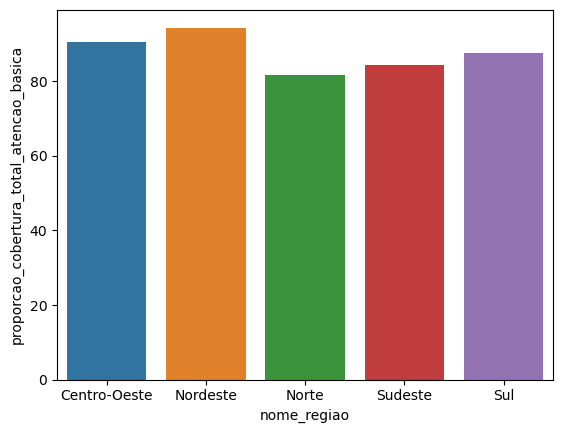

In [61]:
sns.barplot(data=df_unido.groupby('nome_regiao').mean().reset_index(), x='nome_regiao', y='proporcao_cobertura_total_atencao_basica')

<AxesSubplot:xlabel='nome_regiao', ylabel='carga_horaria_medica_atencao_basica_tradicional'>

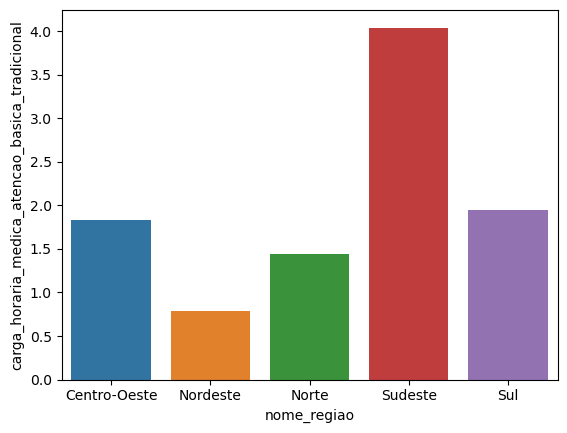

In [62]:
sns.barplot(data=df_unido.groupby('nome_regiao').mean().reset_index(), x='nome_regiao', y='carga_horaria_medica_atencao_basica_tradicional')

<AxesSubplot:xlabel='nome_regiao', ylabel='carga_horaria_enfermagem_atencao_basica_tradicional'>

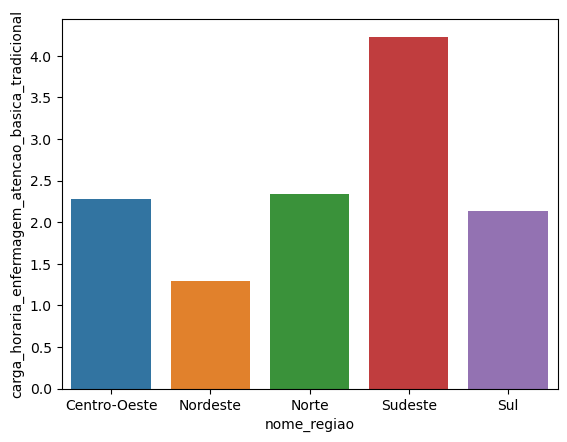

In [63]:
sns.barplot(data=df_unido.groupby('nome_regiao').mean().reset_index(), x='nome_regiao', y='carga_horaria_enfermagem_atencao_basica_tradicional')

In [64]:
df_nordeste = df_unido[df_unido['nome_regiao'] == 'Nordeste']

In [65]:
df_nordeste

,ano,mes,sigla_uf_x,id_municipio,id_municipio_6_x,populacao,carga_horaria_medica_atencao_basica_tradicional,carga_horaria_enfermagem_atencao_basica_tradicional,quantidade_equipes_atencao_basica_equivalente,quantidade_equipes_atencao_basica_parametrizada,...,nome_regiao_intermediaria,id_microrregiao,nome_microrregiao,id_mesorregiao,nome_mesorregiao,ddd,id_uf,sigla_uf_y,nome_uf,nome_regiao
162,2007,7,AL,2700300,270030,202390,0.00,0.0,0,0,...,Arapiraca,27006,Arapiraca,2702,Agreste Alagoano,82,27,AL,Alagoas,Nordeste
163,2007,8,AL,2700300,270030,202390,6.75,1.0,1,0,...,Arapiraca,27006,Arapiraca,2702,Agreste Alagoano,82,27,AL,Alagoas,Nordeste
164,2007,9,AL,2700300,270030,202390,6.75,2.0,2,0,...,Arapiraca,27006,Arapiraca,2702,Agreste Alagoano,82,27,AL,Alagoas,Nordeste
165,2007,10,AL,2700300,270030,202390,6.66,3.0,3,0,...,Arapiraca,27006,Arapiraca,2702,Agreste Alagoano,82,27,AL,Alagoas,Nordeste
166,2007,11,AL,2700300,270030,202390,6.00,4.0,4,0,...,Arapiraca,27006,Arapiraca,2702,Agreste Alagoano,82,27,AL,Alagoas,Nordeste
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901939,2020,7,PE,2610004,261000,63250,0.00,0.0,0,0,...,Recife,26015,Mata Meridional Pernambucana,2604,Mata Pernambucana,81,26,PE,Pernambuco,Nordeste
901940,2020,9,PE,2610004,261000,63250,0.00,0.0,0,0,...,Recife,26015,Mata Meridional Pernambucana,2604,Mata Pernambucana,81,26,PE,Pernambuco,Nordeste
901941,2020,10,PE,2610004,261000,63250,0.00,0.0,0,0,...,Recife,26015,Mata Meridional Pernambucana,2604,Mata Pernambucana,81,26,PE,Pernambuco,Nordeste
901942,2020,11,PE,2610004,261000,63250,0.00,0.0,0,0,...,Recife,26015,Mata Meridional Pernambucana,2604,Mata Pernambucana,81,26,PE,Pernambuco,Nordeste


In [77]:
df_nordeste_estados = df_nordeste.groupby(['sigla_uf_x', 'ano']).mean().reset_index()

In [96]:
df_nordeste_estados[df_nordeste_estados['sigla_uf_x'] == 'AL']

,sigla_uf_x,ano,mes,populacao,carga_horaria_medica_atencao_basica_tradicional,carga_horaria_enfermagem_atencao_basica_tradicional,quantidade_equipes_atencao_basica_equivalente,quantidade_equipes_atencao_basica_parametrizada,quantidade_equipes_saude_familia,quantidade_equipes_atencao_basica_total,populacao_coberta_estrategia_saude_familia,proporcao_cobertura_estrategia_saude_familia,populacao_coberta_total_atencao_basica,proporcao_cobertura_total_atencao_basica,capital_uf
0,AL,2007,9.5,29908.352941,1.088039,0.662745,0.441176,0.0,7.089869,7.531046,20916.789216,93.378186,21884.929739,94.091193,0.009804
1,AL,2008,6.5,29776.77451,1.356716,0.879289,0.602124,0.0,7.216503,7.818627,21276.427288,94.642933,22672.788399,95.491364,0.009804
2,AL,2009,6.5,30662.323529,1.343105,1.061168,0.60866,0.0,7.326797,7.935458,21863.140523,94.639902,23368.555556,95.435025,0.009804
3,AL,2010,6.5,30942.235294,1.290760,1.143186,0.666667,0.0,7.503268,8.169935,22365.526961,95.190351,24098.361111,96.131691,0.009804
4,AL,2011,6.5,30593.078431,0.977361,1.092361,0.579248,0.0,7.474673,8.053922,22158.195261,94.085850,23672.484477,95.001691,0.009804
5,AL,2012,6.5,30817.039216,0.999101,1.212623,0.610294,0.0,7.571078,8.181373,22519.954248,94.760229,24128.988562,95.423015,0.009804
6,AL,2013,6.5,31034.039216,1.139984,1.524060,0.795752,0.006536,7.745098,8.547386,22968.663399,95.463145,25007.64951,96.221283,0.009804
7,AL,2014,6.5,32362.107843,1.205245,1.518137,0.862745,0.007353,8.036765,8.906863,24111.138889,96.466708,26127.487745,97.107925,0.009804
8,AL,2015,6.5,32565.980392,1.139592,1.352492,0.798203,0.0,8.114379,8.912582,24299.654412,96.466560,26190.848856,97.089518,0.009804
9,AL,2016,6.5,32754.235294,1.075384,1.291724,0.71732,0.0,8.236111,8.953431,24606.013889,96.804755,26391.553922,97.292304,0.009804


<AxesSubplot:xlabel='ano', ylabel='proporcao_cobertura_total_atencao_basica'>

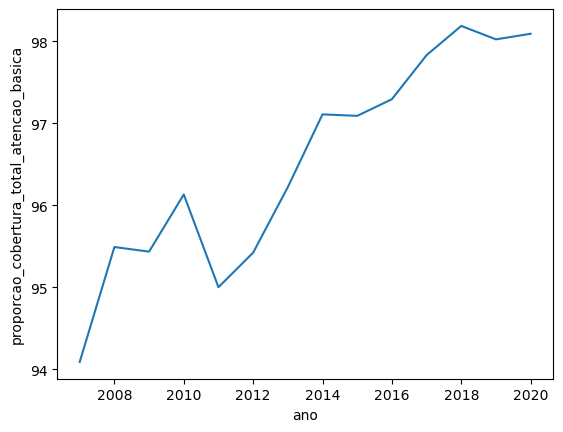

In [100]:
sns.lineplot(data=df_nordeste_estados[df_nordeste_estados['sigla_uf_x'] == 'AL'], x='ano', y='proporcao_cobertura_total_atencao_basica')

<AxesSubplot:xlabel='ano', ylabel='proporcao_cobertura_total_atencao_basica'>

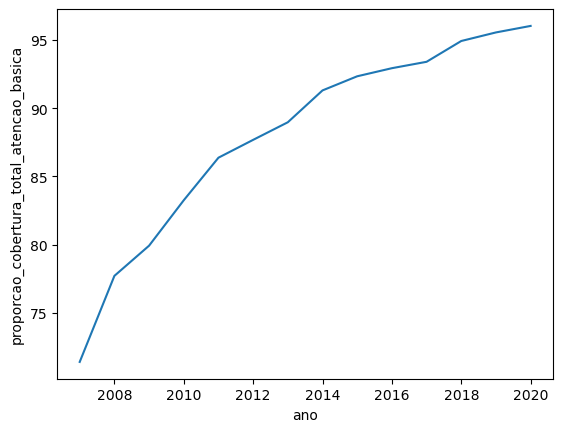

In [101]:
sns.lineplot(data=df_nordeste_estados[df_nordeste_estados['sigla_uf_x'] == 'BA'], x='ano', y='proporcao_cobertura_total_atencao_basica')

<AxesSubplot:xlabel='ano', ylabel='proporcao_cobertura_total_atencao_basica'>

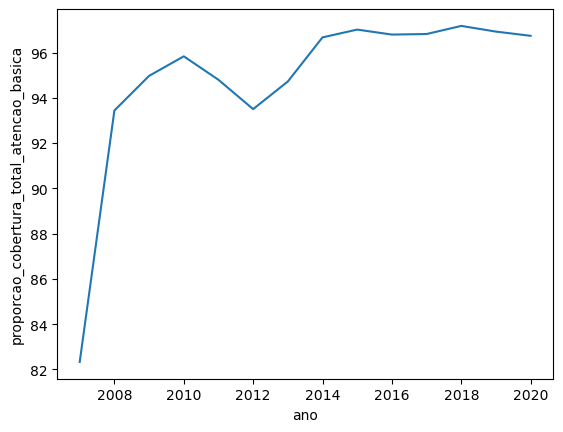

In [102]:
sns.lineplot(data=df_nordeste_estados[df_nordeste_estados['sigla_uf_x'] == 'MA'], x='ano', y='proporcao_cobertura_total_atencao_basica')

<AxesSubplot:xlabel='ano', ylabel='proporcao_cobertura_total_atencao_basica'>

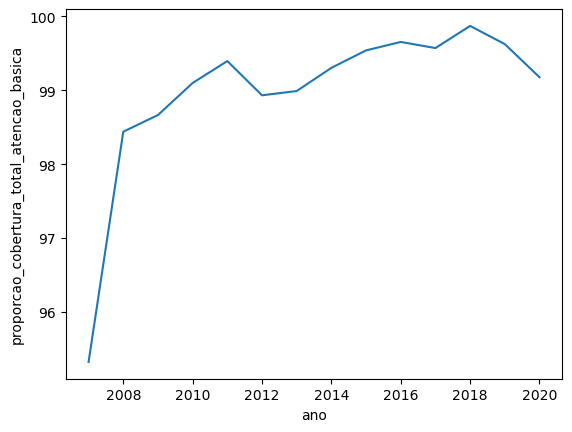

In [103]:
sns.lineplot(data=df_nordeste_estados[df_nordeste_estados['sigla_uf_x'] == 'PI'], x='ano', y='proporcao_cobertura_total_atencao_basica')

<AxesSubplot:xlabel='ano', ylabel='proporcao_cobertura_total_atencao_basica'>

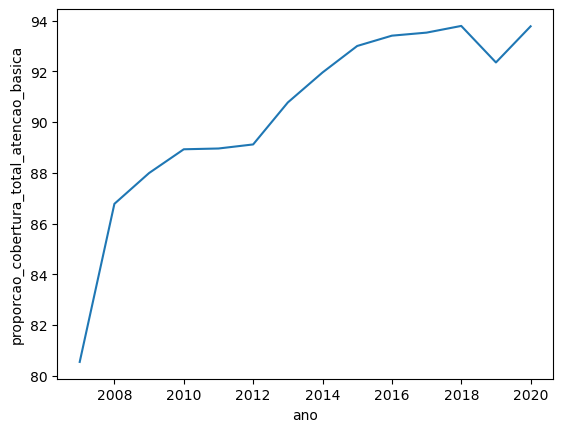

In [104]:
sns.lineplot(data=df_nordeste_estados[df_nordeste_estados['sigla_uf_x'] == 'PE'], x='ano', y='proporcao_cobertura_total_atencao_basica')

<AxesSubplot:xlabel='ano', ylabel='proporcao_cobertura_total_atencao_basica'>

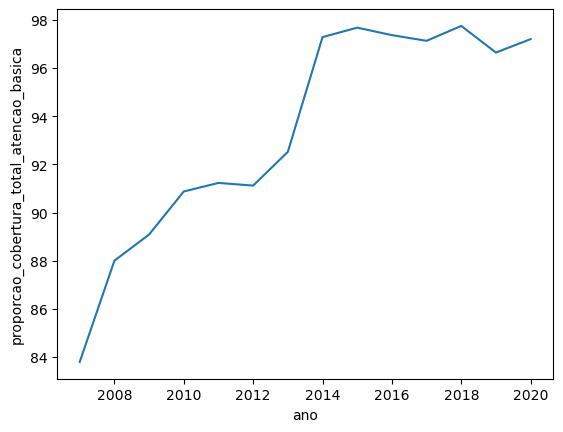

In [105]:
sns.lineplot(data=df_nordeste_estados[df_nordeste_estados['sigla_uf_x'] == 'CE'], x='ano', y='proporcao_cobertura_total_atencao_basica')

<AxesSubplot:xlabel='ano', ylabel='proporcao_cobertura_total_atencao_basica'>

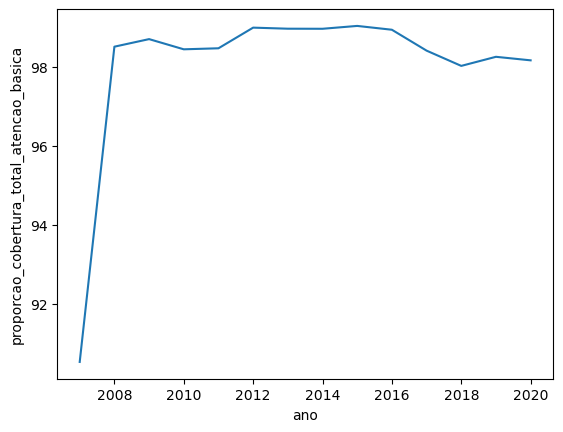

In [106]:
sns.lineplot(data=df_nordeste_estados[df_nordeste_estados['sigla_uf_x'] == 'RN'], x='ano', y='proporcao_cobertura_total_atencao_basica')

<AxesSubplot:xlabel='ano', ylabel='proporcao_cobertura_total_atencao_basica'>

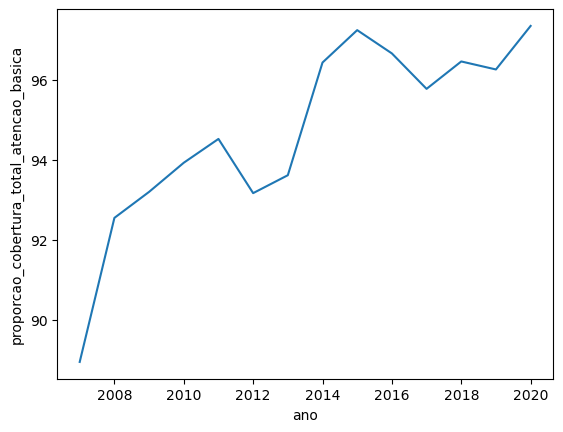

In [107]:
sns.lineplot(data=df_nordeste_estados[df_nordeste_estados['sigla_uf_x'] == 'SE'], x='ano', y='proporcao_cobertura_total_atencao_basica')

<AxesSubplot:xlabel='ano', ylabel='proporcao_cobertura_total_atencao_basica'>

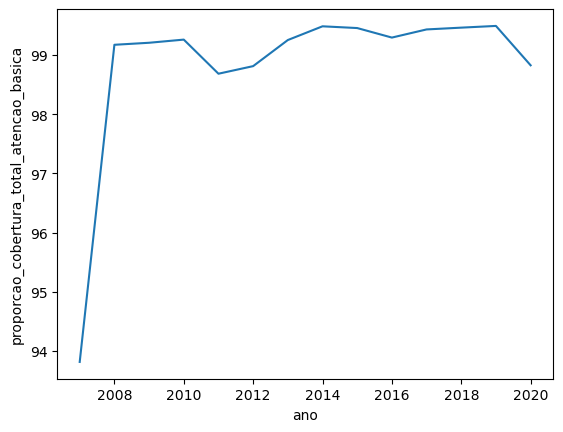

In [108]:
sns.lineplot(data=df_nordeste_estados[df_nordeste_estados['sigla_uf_x'] == 'PB'], x='ano', y='proporcao_cobertura_total_atencao_basica')

In [ ]:
sns.lineplot(data=df_nordeste_estados, )